In [3]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install requests pandas numpy matplotlib ta

Note: you may need to restart the kernel to use updated packages.



=== Fetching data for bitcoin ===
CoinGecko Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 22:26:48
Combined Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 22:26:48
Fetched data for bitcoin: 91 records.

=== Fetching data for ethereum ===
CoinGecko Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 22:33:45
Combined Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 22:33:45
Fetched data for ethereum: 91 records.

=== Fetching data for litecoin ===
CoinGecko Data for litecoin: 2024-07-17 00:00:00 to 2024-10-14 22:44:56
Combined Data for litecoin: 2024-07-17 00:00:00 to 2024-10-14 22:44:56
Fetched data for litecoin: 91 records.


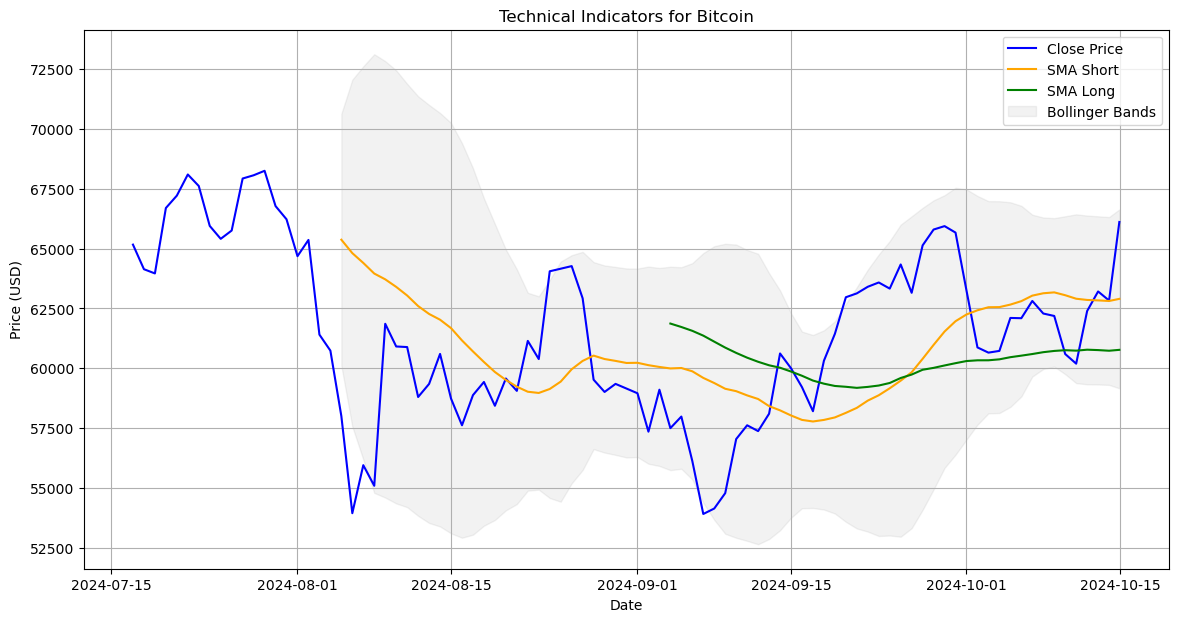

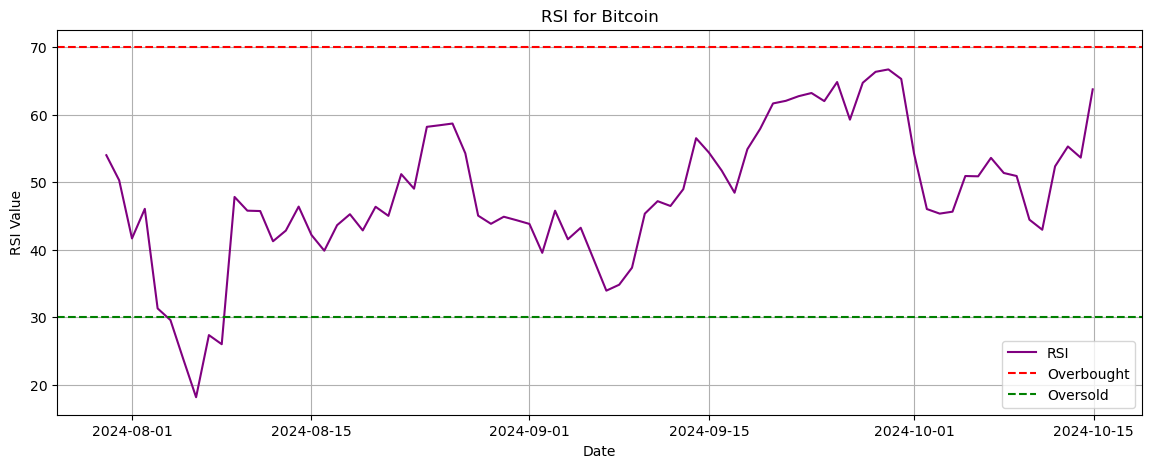

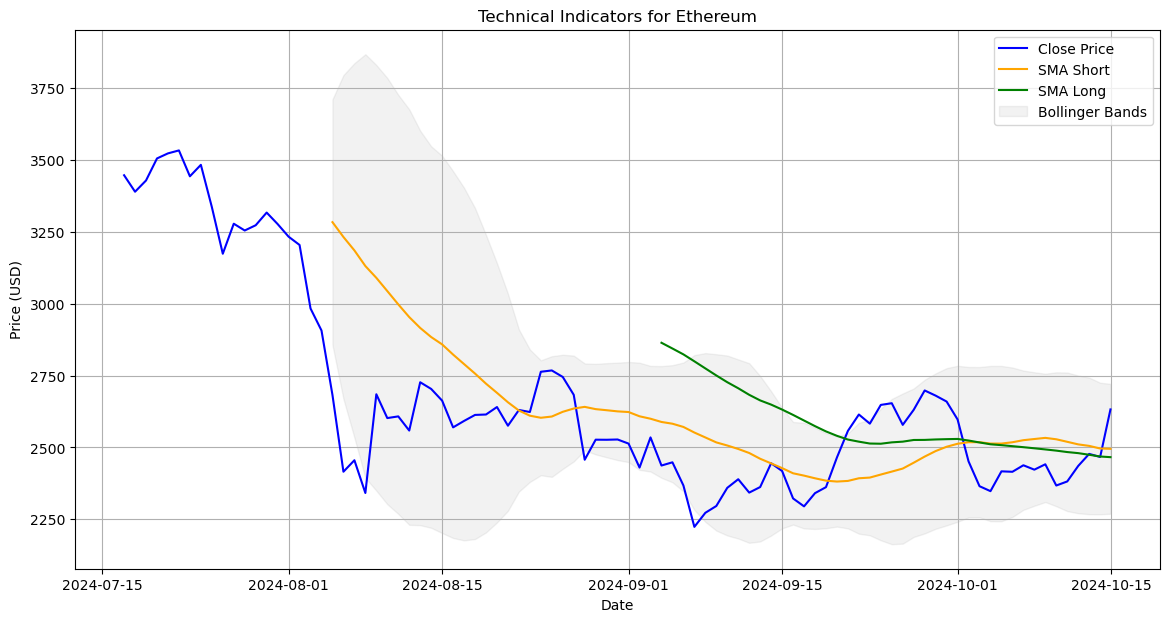

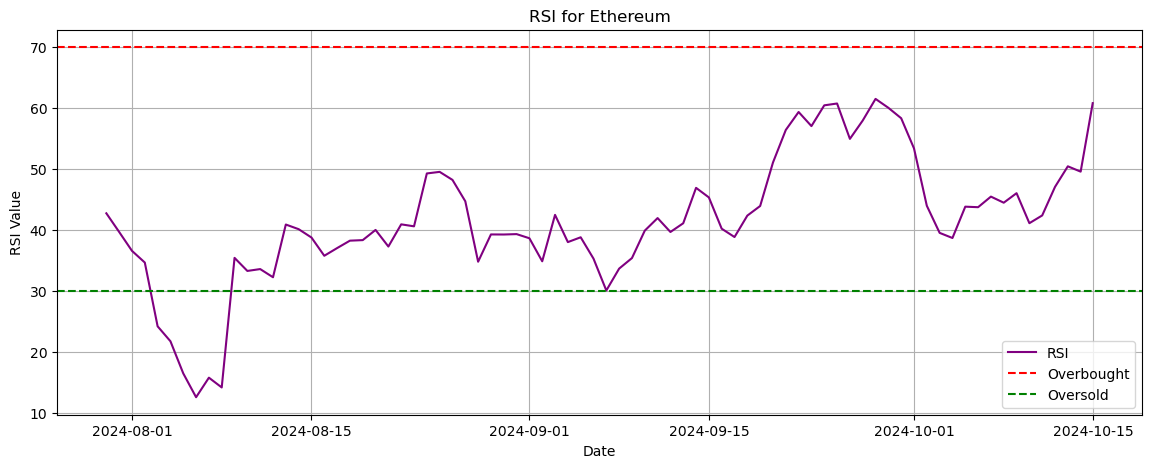

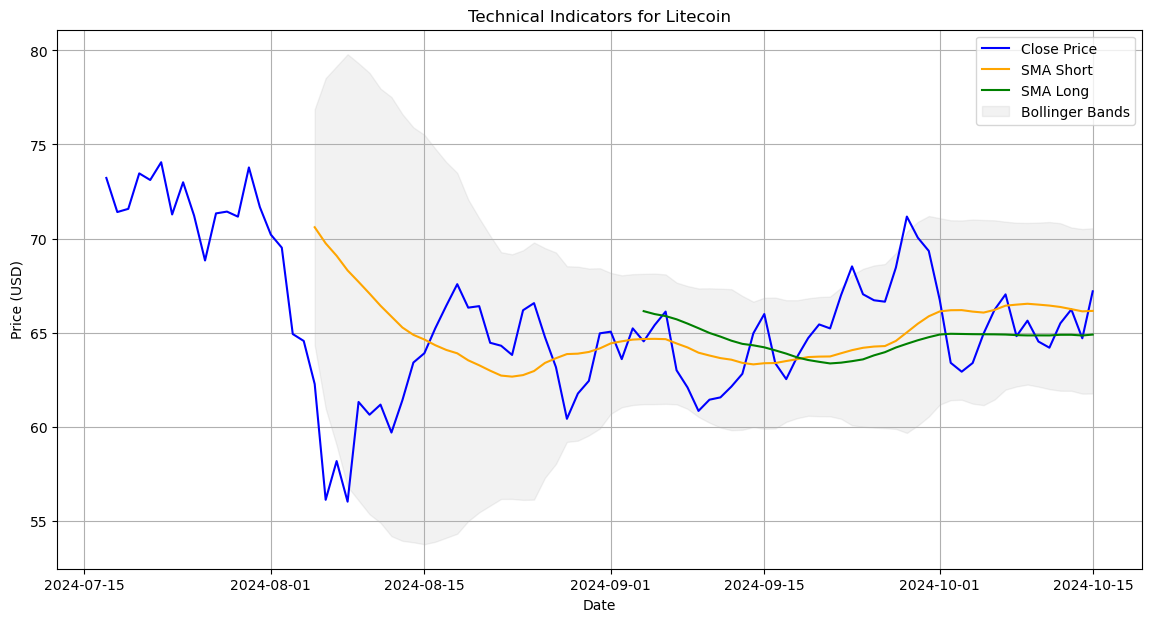

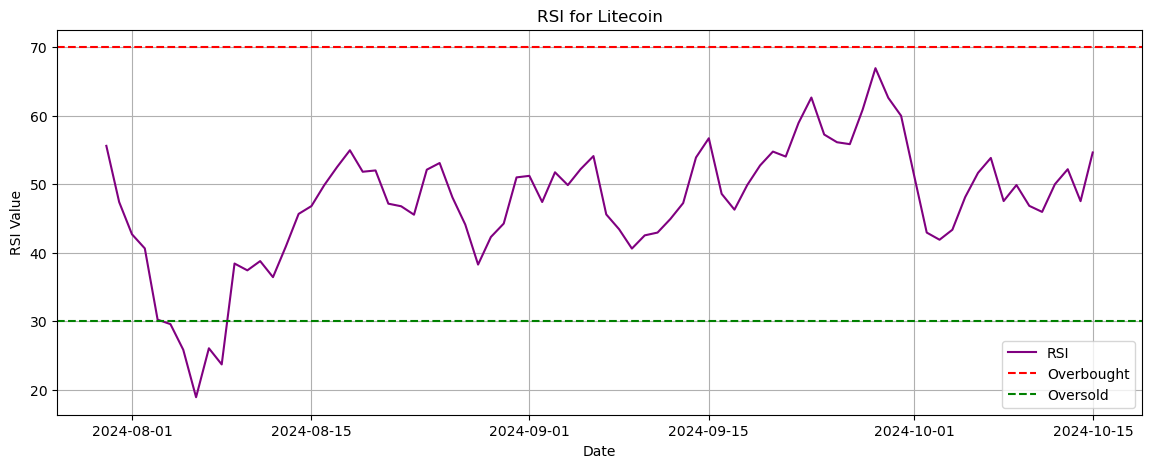

Exchange Rates:
{'bitcoin': {'usd': 66145, 'eur': 60649, 'jpy': 9905576, 'gbp': 50655, 'aud': 98405}, 'ethereum': {'usd': 2636.04, 'eur': 2417.01, 'jpy': 394760, 'gbp': 2018.71, 'aud': 3921.65}, 'litecoin': {'usd': 67.11, 'eur': 61.53, 'jpy': 10049.99, 'gbp': 51.39, 'aud': 99.84}}
                    Cryptocurrency         Close  \
Date                                               
2024-07-17 00:00:00        bitcoin  65162.236252   
2024-07-18 00:00:00        bitcoin  64136.313844   
2024-07-19 00:00:00        bitcoin  63959.569008   
2024-07-20 00:00:00        bitcoin  66689.548807   
2024-07-21 00:00:00        bitcoin  67206.064706   
...                            ...           ...   
2024-10-11 00:00:00       litecoin     64.200798   
2024-10-12 00:00:00       litecoin     65.498170   
2024-10-13 00:00:00       litecoin     66.233789   
2024-10-14 00:00:00       litecoin     64.700605   
2024-10-14 22:44:56       litecoin     67.197248   

                                         

In [6]:
import hashlib
import requests
import pandas as pd
import matplotlib.pyplot as plt
from ta import trend, momentum, volatility

# =========================
# Configuration and Settings
# =========================
# List of cryptocurrencies to analyze (CoinGecko IDs)
CRYPTOCURRENCIES = ['bitcoin', 'ethereum', 'litecoin']

# Fiat currencies for exchange rates
FIAT_CURRENCIES = ['usd', 'eur', 'jpy', 'gbp', 'aud']  # Use lowercase for CoinGecko

# Timeframe for historical data (Last 90 days)
DAYS = '90'  # API may expect string

# Technical indicators settings
SMA_SHORT = 20  # Short-term Simple Moving Average
SMA_LONG = 50   # Long-term Simple Moving Average
RSI_PERIOD = 14

# =========================
# Utility Functions
# =========================
def get_hash(data):
    """Generates a SHA-256 hash for the given data."""
    hash_object = hashlib.sha256(data.encode())
    return hash_object.hexdigest()

# =========================
# Data Fetching Functions
# =========================
def fetch_coin_gecko_data(crypto_id, vs_currency='usd', days=DAYS):
    """Fetches historical market data for a cryptocurrency from CoinGecko."""
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        prices['Date'] = pd.to_datetime(prices['timestamp'], unit='ms')
        prices.set_index('Date', inplace=True)
        prices['Close'] = prices['price']
        prices = prices[['Close']].sort_index()

        # Verification
        print(f"CoinGecko Data for {crypto_id}: {prices.index.min()} to {prices.index.max()}")

        prices['Hash'] = prices['Close'].apply(lambda x: get_hash(str(x)))
        return prices
    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error for {crypto_id}: {e}")
        return pd.DataFrame()

def fetch_exchange_rates():
    """Fetches exchange rates for cryptocurrencies against FIAT currencies."""
    url = f'https://api.coingecko.com/api/v3/simple/price'

    # Create a comma-separated string of cryptocurrency IDs
    crypto_ids = ','.join(CRYPTOCURRENCIES)
    params = {
        'ids': crypto_ids,
        'vs_currencies': ','.join(FIAT_CURRENCIES)
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        print("Exchange Rates:")
        print(data)
        return data
    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error: {e}")
        return None

# Placeholder function for mapping cryptocurrency symbols
def crypto_symbol_mapping(crypto):
    """Maps CoinGecko cryptocurrency IDs to another source's symbols (placeholder)."""
    mapping = {
        'bitcoin': 'BTC',
        'ethereum': 'ETH',
        'litecoin': 'LTC'
    }
    return mapping.get(crypto)

# Placeholder functions for other data sources
def fetch_cryptocompare_data(symbol):
    """Placeholder for fetching data from CryptoCompare."""
    return pd.DataFrame()  # Implement actual API call

# Other placeholder functions (omitted for brevity)

def perform_technical_analysis(df):
    """Applies technical indicators to the DataFrame using the `ta` library."""
    df['Close'] = df['Close'].astype(float)  # Ensure 'Close' is in float
    df.dropna(subset=['Close'], inplace=True)  # Drop NaN values if necessary
    df['SMA_Short'] = trend.sma_indicator(close=df['Close'], window=SMA_SHORT)
    df['SMA_Long'] = trend.sma_indicator(close=df['Close'], window=SMA_LONG)
    df['RSI'] = momentum.rsi(close=df['Close'], window=RSI_PERIOD)

    # Corrected BollingerBands usage
    bollinger = volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()

    return df

def identify_trends(df):
    """Identifies upward and downward trends based on technical indicators."""
    df['Trend'] = 'Neutral'
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Trend'] = 'Uptrend'
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Trend'] = 'Downtrend'
    df['RSI_Status'] = 'Neutral'
    df.loc[df['RSI'] > 70, 'RSI_Status'] = 'Overbought'
    df.loc[df['RSI'] < 30, 'RSI_Status'] = 'Oversold'
    return df

def plot_technical_indicators(df, crypto):
    """Plots the technical indicators for the given cryptocurrency."""
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.plot(df.index, df['SMA_Short'], label='SMA Short', color='orange')
    plt.plot(df.index, df['SMA_Long'], label='SMA Long', color='green')
    plt.fill_between(df.index, df['Bollinger_Low'], df['Bollinger_High'], color='grey', alpha=0.1, label='Bollinger Bands')
    plt.title(f"Technical Indicators for {crypto.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

def fetch_all_crypto_data():
    """Fetches historical data from multiple sources for all cryptocurrencies."""
    crypto_data = {}
    for crypto in CRYPTOCURRENCIES:
        print(f"\n=== Fetching data for {crypto} ===")
        data_frames = []

        # 1. CoinGecko
        cg_data = fetch_coin_gecko_data(crypto)
        if not cg_data.empty:
            data_frames.append(cg_data)

        # 2. CryptoCompare
        cc_symbol = crypto_symbol_mapping(crypto)  # Ensure this function is defined
        if cc_symbol:
            cc_data = fetch_cryptocompare_data(cc_symbol)
            if not cc_data.empty:
                data_frames.append(cc_data)

        # Additional API data fetching...
        
        if not data_frames:
            print(f"No data fetched for {crypto}. Skipping.")
            continue
        
        # Combine all data frames on Date index
        combined = pd.concat(data_frames, axis=1)

        # Calculate mean Close price across available sources
        combined['Close'] = combined.filter(like='Close').mean(axis=1)
        combined = combined[['Close']].sort_index()

        # Verification of date range
        print(f"Combined Data for {crypto}: {combined.index.min()} to {combined.index.max()}")

        # Assign Data ID
        combined['Data ID'] = combined.index.to_series().apply(lambda x: get_hash(x.strftime('%Y-%m-%d')))

        # Store in crypto_data dictionary
        crypto_data[crypto] = combined
        print(f"Fetched data for {crypto}: {combined.shape[0]} records.")

    return crypto_data

def plot_rsi(df, crypto):
    """Plots the RSI for the given cryptocurrency."""
    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', label='Overbought')
    plt.axhline(30, linestyle='--', color='green', label='Oversold')
    plt.title(f"RSI for {crypto.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid()
    plt.show()

def display_data_as_table(data_dict):
    """Displays the dataset as a table."""
    # Concatenate all DataFrames into a single DataFrame for display
    combined_df = pd.concat(data_dict.values(), keys=data_dict.keys())
    combined_df = combined_df.reset_index(level=0).rename(columns={'level_0': 'Cryptocurrency'})
    print(combined_df)

# =========================
# Main Execution Flow
# =========================
if __name__ == "__main__":
    all_crypto_data = fetch_all_crypto_data()

    # Perform technical analysis and plotting
    for crypto, df in all_crypto_data.items():
        analyzed_df = perform_technical_analysis(df)
        trend_identified_df = identify_trends(analyzed_df)

        # Plotting the technical indicators and RSI
        plot_technical_indicators(trend_identified_df, crypto)
        plot_rsi(trend_identified_df, crypto)

    # Fetch exchange rates once for all cryptocurrencies
    fetch_exchange_rates()

    # Display the fetched data as a table
    display_data_as_table(all_crypto_data)